# 합성곱 신경망(Convolutional neural networks)

이전 챕터에서 우리는 클래스 정의를 사용하여 Multi-Layer 신경망을 정의하는 방법을 배웠지만 이러한 네트워크는 일반적이며 동시에 컴퓨터 비전 작업에 특화되지 않았습니다. 이 챕터에서는 컴퓨터 비전을 위해 특별히 설계된 **CNN (Convolutional Neural Networks)** 에 대해 알아 봅니다.

컴퓨터 비전은 일반 분류 문제와 다릅니다. 사진에서 특정 물체를 찾으려고 할 때 이미지를 스캔하여 특정 **패턴(Pattern)** 과 그 조합을 찾습니다. 예를 들어 고양이를 찾을 때 먼저 수염을 형성할 수있는 수평선을 찾은 다음 특정 수염 조합을 통해 실제로 고양이의 사진임을 알 수 있습니다. 이미지에서의 정확한 위치가 아니라 특정 패턴의 상대적 위치와 존재가 중요합니다.

패턴을 추출하기 위해 **Convolution Filters**라는 개념을 사용합니다. 하지만 먼저 이전 챕터에서 정의한 모든 종속성(dependencies)과 함수를 로드하겠습니다.

In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np

from pytorchcv import load_mnist, train, plot_results, plot_convolution, display_dataset
load_mnist(batch_size=128)

## Convolutional filters

Convolutional Filters는 이미지의 각 픽셀에 걸쳐 실행되고 인접 픽셀의 가중 평균(Weighted Average)을 계산하는 작은 Window입니다.



이는 가중치 계수 행렬로 정의됩니다. MNIST에 서로 다른 2개의 Convolutional Filter를 적용하는 예를 살펴 보겠습니다.

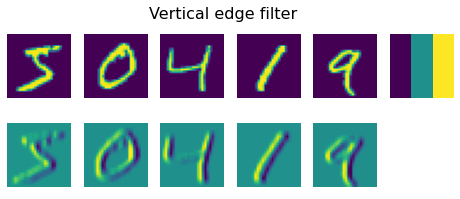

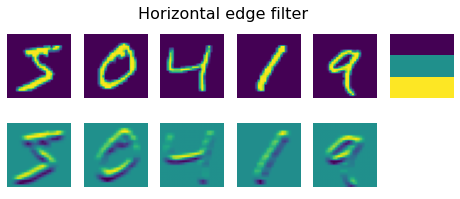

In [2]:
plot_convolution(torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),'Vertical edge filter')
plot_convolution(torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),'Horizontal edge filter')

첫 번째 Filter는 **Vertical Edge Filter**라고 하며, 아래 행렬로 정의됩니다.
$$
\left(
    \begin{matrix}
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
    \end{matrix}
\right)
$$
이 Filter가 상대적으로 균일한(Uniform) Pixel Field를 통과하면 모든 값의 합이 0이 됩니다. 그러나 이미지에서 수직 가장자리(Vertical Edge)를 만나면 높은 스파이크(High Spike) 값이 생성됩니다. 그렇기 때문에 위의 이미지에서 높은 값과 낮은 값으로 표시되는 수직 가장자리를 볼 수 있고, 수평 가장자리(Horizontal Edge)는 평균화(Averaged Out)됩니다.

두 번째 Filter인 **Horizontal Edge Filter**를 적용하면 반대 현상이 발생합니다. 수평선은 증폭되고 수직선은 평균화됩니다.

고전적인 컴퓨터 비전에서는 여러 Filter를 이미지에 적용하여 Feature를 생성한 다음 머신 러닝 알고리즘에서 분류기를 구축하는 데 사용했습니다. 그러나 딥 러닝에서는 분류 문제를 해결하기 위해 최상의 Confolutional Filter를 학습하는 네트워크를 구성합니다.

이를 위해 **Convolutional Layers**를 소개합니다.

## Covolutional layers

Convolutional Laye는 `nn.Conv2d`를 사용하여 정의되며, 아래 파라미터를 지정해야 합니다.
* `in_channels` : 입력 채널 수. 아래 예제에서는 흑백 이미지를 다루기 때문에 입력 채널 수는 1입니다.
* `out_channels` : 사용할 Filter의 수. 아래 예제에서는 9개의 다른 Filter를 사용할 것이며, 이는 어떤 Filter가 시나리오에 가장 적합한지 네트워크에서 탐색할 수 있습니다.
* `kernel_size` : Sliding Window의 크기입니다. 일반적으로 3x3 또는 5x5 Filter를 사용합니다.

가장 단순한 CNN은 하나의 Convolutional Layer를 포함합니다. 입력 크기가 28x28이라면, 9개의 5x5 필터를 적용한 후 9x24x24의 Tensor를 얻게 됩니다(길이가 5인 슬라이딩 간격이 28 픽셀에 들어갈 수 있는 위치는 24 개 뿐이기 때문에 공간 크기는 더 작아집니다).

Confolutional Layer를 거친 후, 9x24x24의 Tensor를 크기가 5,184 인 하나의 Vector로 병합한 다음 선형 Layer를 추가하여 10개의 클래스를 생성합니다. 또한 Layer 사이에 `relu` 활성화 함수를 사용합니다.

In [6]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(5184,10)

    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = OneConv()

summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [1, 9, 24, 24]            234
├─Flatten: 1-2                           [1, 5184]                 --
├─Linear: 1-3                            [1, 10]                   51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Total Size (MB): 0.25

이 네트워크에는 완전히 연결된(Fully-Connected) Multi-Layer Network의 약 80k개의 매개 변수에 비해 약 50k개의 훈련 가능한 파라미터가 포함되어 있음을 알 수 있습니다. 이를 통해 Convolutional Network가 훨씬 더 잘 일반화되기 때문에 작은 데이터셋에서도 좋은 결과를 얻을 수 있습니다.

Epoch  0, Train acc=0.947, Val acc=0.969, Train loss=0.001, Val loss=0.001
Epoch  1, Train acc=0.979, Val acc=0.975, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.985, Val acc=0.977, Train loss=0.000, Val loss=0.001
Epoch  3, Train acc=0.988, Val acc=0.975, Train loss=0.000, Val loss=0.001
Epoch  4, Train acc=0.988, Val acc=0.976, Train loss=0.000, Val loss=0.001


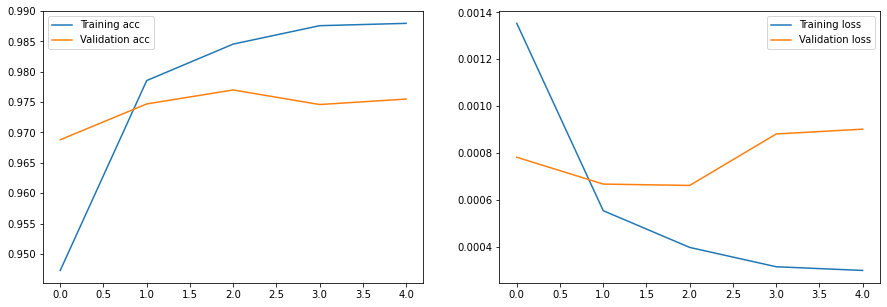

In [7]:
hist = train(net,train_loader,test_loader,epochs=5)
plot_results(hist)

보시다시피 이전 챕터의 완전 연결층 네트워크에 비해 더 높은 정확도와 훨씬 더 빠른 속도를 얻을 수 있습니다.

또한 훈련된 Convolutional Layer의 가중치를 시각화하여 진행 상황을 좀 더 이해할 수 있습니다.

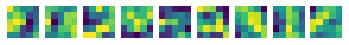

In [9]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

어떤 Filter는 비스듬한 스트로크(stroke)를 인식할 수 있는 것처럼 보이지만, 다른 Filter는 무작위로 보입니다.

## Multi-layered CNNs and pooling layers

첫 번째 Convolutional Layer는 수평선 또는 수직선과 같은 기본 패턴을 찾지만, 추가 Convolutional Layer를 적용하여 기본 모양과 같은 더 높은 수준의 Pattern을 찾을 수 있습니다. 그런 다음 더 많은 Convolutional Layer가 더 많은 그림의 일부를 결합하여 분류하려는 최종 개체까지 만들 수 있습니다.

이때 이미지의 공간 크기를 줄이는 한 가지 트릭을 적용 할 수도 있습니다. Sliding Window 3x3 내에 수평 스트로크가 있음을 감지하면 정확히 어떤 픽셀이 발생했는지는 그다지 중요하지 않습니다. 따라서 **Pooling Layer** 중 하나를 사용하여 이미지 크기를 축소할 수 있습니다.

 * **Average Pooling** : Sliding Window(예 : 2x2 Pixel)를 사용하여 Window 내 값의 평균을 계산합니다.
 * **Max Pooling** : Window 내 값을 최대 값으로 대체합니다. Max Pooling의 기본 개념은 Sliding Window 내에서 특정 Pattern의 존재를 감지하는 것입니다.

따라서 일반적인 CNN에는 이미지 크기를 줄이기 위해 그 사이에 Pooling Layer가 있는 여러 개의 Convolutional Layer가 있습니다. Pattern이 더욱 발전함에 따라 우리가 찾아야 할 더 많은 흥미로운 조합이 있기 때문에 우리는 또한 Filter 수를 늘릴 것입니다.

![An image showing several convolutional layers with pooling layers.](./images/cnn-pyramid.png)

Spatial 차원이 감소하고 Feature/Filter 차원이 증가하기 때문에 이 아키텍쳐를 **Pyramid Architecture**라고도 합니다.

In [13]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = MultiLayerCNN()
summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

위 정의에 대해 몇 가지 사항을 유의하십시오.
* `Flatten` Layer를 사용하는 대신 `view` 함수를 사용하여 `forward` 함수 내에 Tensor를 병합합니다. Flatten Layer에는 학습 가능한 가중치가 없기 때문에 클래스 내에 별도의 Layer Instance를 생성할 필요가 없습니다.
* 학습 가능한 파라미터가 포함되어 있지 않기 때문에 모델에서 Pooling Layer의 Instance 하나만 사용하며, 이 Instance 하나는 효과적으로 재사용할 수 있습니다.
* 학습 가능한 파라미터의 수(~8.5K)가 이전 케이스보다 훨씬 적습니다. 이는 일반적으로 Convolutional Layer에 파라미터가 거의 없고 최종 Dense Layer를 적용하기 전 이미지의 차원이 크게 감소하기 때문에 발생합니다. 적은 수의 파라미터는 더 작은 데이터셋 크기에서도 과적합을 방지하는 데 도움이 되므로 모델에 긍정적인 영향을 미칩니다.

In [14]:
hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.952, Val acc=0.977, Train loss=0.001, Val loss=0.001
Epoch  1, Train acc=0.982, Val acc=0.983, Train loss=0.000, Val loss=0.000
Epoch  2, Train acc=0.986, Val acc=0.983, Train loss=0.000, Val loss=0.000
Epoch  3, Train acc=0.986, Val acc=0.978, Train loss=0.000, Val loss=0.001
Epoch  4, Train acc=0.987, Val acc=0.981, Train loss=0.000, Val loss=0.000


여기서 관찰해야 할 것은 하나의 Layer보다 더 높은 정확도를 얻을 수 있다는 것입니다. 이는 정교한 네트워크 아키텍처가 무슨 일이 일어나고 있는지 파악하고 이미지에서 일반적인 Pattern을 추출하는 데 훨씬 적은 데이터가 필요함을 의미합니다.

## Playing with real images from the CIFAR-10 dataset

손으로 쓴 숫자 인식 문제가 쉬운 문제라고 생각된다면, 이제 [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)라고 불리는 더 어려운 문제를 해결할 준비가 되었습니다. 여기에는 10개의 클래스로 나눠진 60K개의 32x32 이미지가 포함되어 있습니다.

In [22]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=14, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


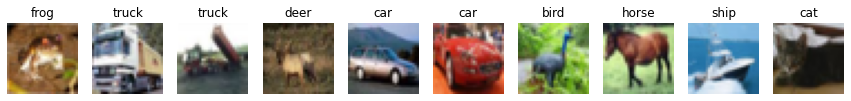

In [23]:
display_dataset(trainset,classes=classes)

CIFAR-10 데이터를 분석하는 아키텍처 중 하나는 [LeNet](https://en.wikipedia.org/wiki/LeNet)으로, *Yann LeCun*이 제안했습니다. 위에서 설명한 것과 동일한 원칙을 따르며, 주된 차이점은 1개가 아닌 3개의 입력 색상 채널입니다.

또한 이 모델은 한 가지 더 단순화 작업을 진행합니다. 즉, 출력 활성화 함수로 `log_softmax`를 사용하지 않고 마지막 완전 연결층(Full-Connected Layer)의 출력만 반환합니다. 이 경우 `CrossEntropyLoss`를 사용하여 모델을 최적화 할 수 있습니다.

In [25]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,120,5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120,64)
        self.fc2 = nn.Linear(64,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = LeNet()

summary(net,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (M): 0.65
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

이 네트워크를 올바르게 훈련하려면 상당한 시간이 걸리며 GPU 지원 컴퓨팅에서 수행하는 것이 좋습니다.

In [26]:
opt = torch.optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
hist = train(net, trainloader, testloader, epochs=3, optimizer=opt, loss_fn=nn.CrossEntropyLoss())

Epoch  0, Train acc=0.261, Val acc=0.388, Train loss=0.143, Val loss=0.121
Epoch  1, Train acc=0.437, Val acc=0.491, Train loss=0.110, Val loss=0.101
Epoch  2, Train acc=0.508, Val acc=0.522, Train loss=0.097, Val loss=0.094


3 Epoch 훈련으로 달성한 정확도는 좋지 않아 보입니다. 그러나 CIFAR-10은 MNIST에 비해 훨씬 어렵다는 것을 기억하십시오. 짧은 훈련 시간에 50% 이상의 정확도를 얻는 것은 좋은 성과라고 할 수 있습니다.

## Takeaways

이 챕터에서는 컴퓨터 비전 신경망의 주요 개념인 합성곱 네트워크를 학습했습니다. 이미지의 분류, 객체 감지 및 심지어 이미지 생성 네트워크까지 지원하는 실제 Architecture는 모두 CNN을 기반으로 하며, 더 많은 Layer와 몇 가지 추가 트릭이 있을 뿐입니다.